In [5]:
from collections import defaultdict
import csv
import numpy as np

POLICIES = [
    ("0", "0"),
    ("0", "1"),
    ("-1", "0"),
    ("-1", "1"),
]
LABELS = {
    ("0", "0"): "GCS, local",
    ("0", "1"): "GCS, remote",
    ("-1", "0"): "Lineage stash, local",
    ("-1", "1"): "Lineage stash, remote",
}

def get_latencies(directory):
    all_latencies = {}
    for policy in POLICIES:
        all_latencies[policy] = defaultdict(list)
    with open('/home/stephanie/ray-fork/results/{}/min_latency_many.csv'.format(directory), 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            key = int(row['num_shards'])
            policy = (row['gcs'], row['remote'])
            latencies = all_latencies[policy]
            latencies[key].append(float(row['min_latency']) * 1000 / 2)
    return all_latencies

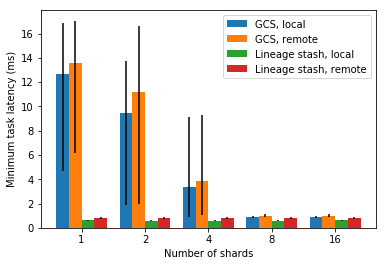

In [7]:
import matplotlib.pyplot as plt

DIRECTORY = "latencies2"
WIDTH = 0.8 / len(POLICIES)

def plot_line(plt, results, label, index=None):
    ticks = np.array(sorted(results.keys()))
    means = []
    yerr_low = []
    yerr_high = []
    for tick in ticks:
        mean = np.mean(results[tick])
        means.append(mean)
        yerr_low.append(
            mean - np.quantile(results[tick], 0.025)
        )
        yerr_high.append(
            np.quantile(results[tick], 0.975) - mean
        )
    x = np.arange(len(ticks))
    plt.bar(x + index * WIDTH, means, yerr=[yerr_low, yerr_high], width=WIDTH, label=label)
    plt.xticks(x + 3 * WIDTH / 2, ticks)

all_latencies = get_latencies(DIRECTORY)
for i, policy in enumerate(POLICIES):
    plot_line(plt, all_latencies[policy], LABELS[policy], index=i)
# plot_line(plt, gcs_latencies, "GCS", index=0)
# plot_line(plt, lineage_stash_latencies, "Lineage stash", index=1)

plt.xlabel("Number of shards")
plt.ylabel("Minimum task latency (ms)")
plt.legend()
# plt.show()

plt.savefig("/home/stephanie/ray-fork/results/{}/min_latency.pdf".format(DIRECTORY))